In [1]:
import pandas as pd
import glob

data_path = sorted(glob.glob("data/*.csv"))[-1]
df = pd.read_csv(data_path, index_col=0)

df.price = df.price.str.replace('zł/mc', '').str.strip().astype(int)
df.Kaucja = df.Kaucja.str.replace('zapytaj', '-1').str.replace('zł', '').str.replace(' ', '').str.strip().astype(int)

df.rooms = df.rooms.apply(lambda x: [int(d) for d in x if d.isdigit()][0])
df.area = df.area.str.replace('m2', '').str.strip().astype(float)

df[['city', 'district_l1', 'district_l2', 'street']] = df.localization_info.str.split(',', expand=True)
df.street = df.street.fillna(df.district_l2)

df.drop(['Powierzchnia', 'Obsługa zdalna','Stan wykończenia'], axis=1, inplace=True)
df.Czynsz = df.Czynsz.str.replace('zapytaj', '-1').str.replace('zł/miesiąc', '').str.replace(' ', '').astype(int)

df.city=df.city.str.strip()
df.district_l1=df.district_l1.str.strip()
df.district_l2=df.district_l2.str.strip()
df.street=df.street.str.strip().fillna('')
df.localization_info.replace(',', '')

mean_czynsz = int(df[df.Czynsz>0].Czynsz.mean())
mean_czynsz
df['_czynsz'] = df.Czynsz.replace(-1, mean_czynsz)
df['_price'] = df.price + df._czynsz

## Price Threshold

In [3]:
import numpy as np

def get_price_threshold(x):
    return 2300 - 1.9*(1 - np.exp(0.095*x))

df['fake'] = get_price_threshold(df.area)>df.price

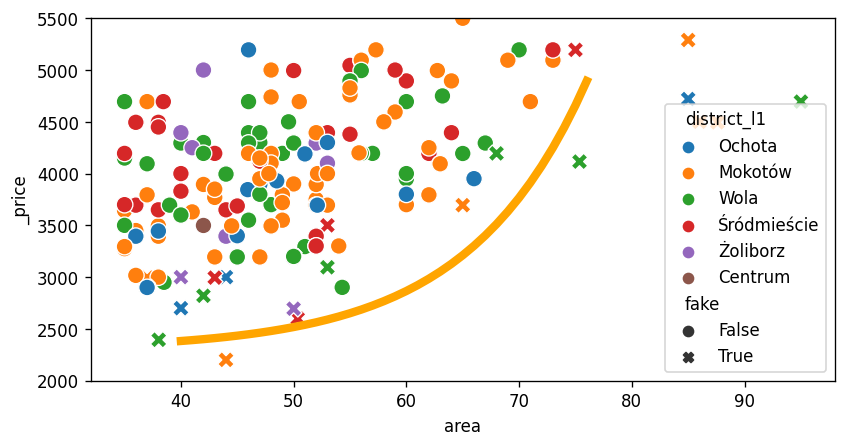

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib.pyplot import figure

figure(figsize=(8, 4), dpi=120)
sns.scatterplot(data=df, x='area', y='_price', hue='district_l1', style='fake', s=100)
x = np.linspace(40,76,37)

y = get_price_threshold(x)
plt.plot(x,y,c='orange', lw=5)
plt.ylim(2000,5500)
plt.show()

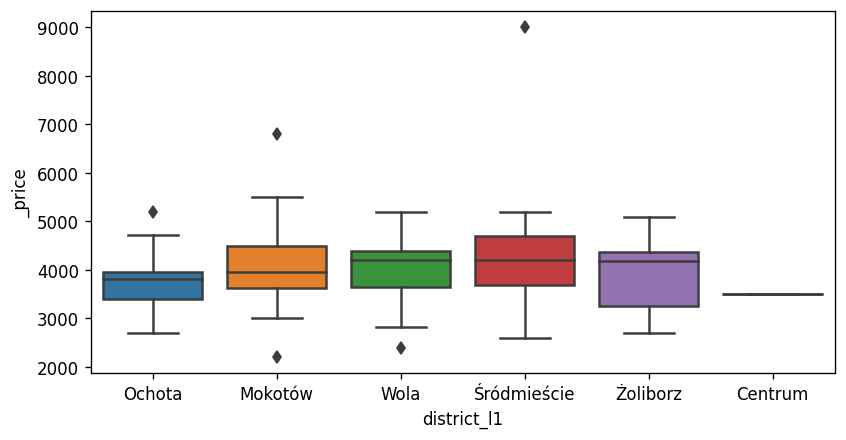

In [5]:
figure(figsize=(8, 4), dpi=120)
sns.boxplot(data=df, x='district_l1', y='_price')
plt.show()

## Filter fake

In [6]:
df['points'] = (10000*df.area/df._price).astype(int)

df = df[df.fake==False].sort_values('points', ascending=False).reset_index(drop=True)

## Load distances/duration

('52.2304944', '21.010445040894194')


(6.4669, 10.495000000000001)


## Download the data

In [ ]:
from tqdm import tqdm
from utils import *

for i, row in tqdm(df.iterrows(), total=len(df)):
    row = df.loc[i]
    address = " ".join([row.city, row.district_l1, row.street]).replace('ul. ', '')
    lat, lon = get_lat_lon(address)
    distance, duration = get_dist_time_cen(lat, lon)    
    df.at[i, 'lat'] = lat
    df.at[i, 'lon'] = lon
    df.at[i, 'distance'] = distance
    df.at[i, 'duration'] = duration

  6%|███████▊                                                                                                                               | 9/155 [00:06<01:36,  1.51it/s]

Warszawa Wola Szulborska 3/5


 14%|██████████████████▏                                                                                                                   | 21/155 [00:13<01:18,  1.72it/s]

Warszawa Mokotów os. Wolfganga Amadeusa Mozarta


 38%|███████████████████████████████████████████████████                                                                                   | 59/155 [00:44<01:05,  1.46it/s]

Warszawa Ochota Rakowska


 41%|███████████████████████████████████████████████████████▎                                                                              | 64/155 [00:47<01:03,  1.43it/s]

Warszawa Ochota Białobrzewska/ Rokosowka


 61%|██████████████████████████████████████████████████████████████████████████████████▏                                                   | 95/155 [01:11<00:42,  1.41it/s]

Warszawa Wola Pokorna


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 155/155 [01:56<00:00,  1.33it/s]


In [21]:
from datetime import datetime
current_time = datetime.now().strftime("%Y_%m_%d__%H_%M_%S")
df.to_csv(f'data/processed/processed_data_{current_time}.csv')

In [48]:
df.iloc[:5,5:]

,listing_url,Czynsz,Liczba pokoi,Kaucja,Piętro,Rodzaj zabudowy,Dostępne od,Balkon / ogród / taras,city,district_l1,district_l2,street,_czynsz,_price,fake,points,lat,lon,distance,duration
0,https://www.otodom.pl/pl/oferta/bliska-wola-me...,1,3,2900,10/10,blok,zapytaj,balkon,Warszawa,Wola,ul. Księcia Janusza,ul. Księcia Janusza,1,2901,False,187,52.2393568,20.9423473,6.5006,11.818333
1,https://www.otodom.pl/pl/oferta/kamienica-2-po...,1,2,5000,parter/5,kamienica,zapytaj,zapytaj,Warszawa,Ochota,Stara Ochota,Stara Ochota,1,3951,False,167,52.21691,20.97827,3.1745,6.601667
2,https://www.otodom.pl/pl/oferta/dwustronne-3-p...,-1,3,-1,2/3,blok,2022-06-01,balkon,Warszawa,Mokotów,Sadyba,Stanisława Pyjasa,695,3795,False,163,52.1952488,21.0535566,8.2713,12.830000
3,https://www.otodom.pl/pl/oferta/3-osobne-pokoj...,1,3,3300,2/8,blok,zapytaj,balkon,Warszawa,Mokotów,ul. Giordana Bruna,ul. Giordana Bruna,1,3301,False,163,52.2089046,21.0024727,3.6949,7.176667
4,https://www.otodom.pl/pl/oferta/przytulne-zadb...,800,2,-1,1/10,blok,zapytaj,zapytaj,Warszawa,Mokotów,None,,800,3700,False,162,52.1939874,21.0457809,6.1176,11.738333


In [82]:
import textwrap

def print_data(data):
    for i, row in data.iterrows():
        row = df.loc[i]
        current_date = datetime.now().strftime("%y_%m_%d")
        if np.isnan(row.distance):
            row.distance = "???"
            row.duration = "???"
        else:
            row.distance = round(row.distance,1)
            row.duration = round(row.distance)
        if abs(row.Czynsz)==1:
            czynsz="plus czynsz ??? zł"
            price = row.price
        else:
            czynsz= f"w tym czysz {row.Czynsz}zł"
            price = row.price + row.Czynsz

        print(textwrap.dedent(f"""
            [{current_date}:{i}] --------------------------------------------------------
            {row.localization_info.replace("Warszawa, ", "")} ({row.distance}km, {row.duration}min do centrum)
            {price}zł ({czynsz}) | {row.rooms} pokoje | {int(row.area)} m2 | piętro {row.Piętro} {row['Rodzaj zabudowy']} 
            {row.listing_url} 
        """))
# print_data(df)

In [24]:

# from email.mime.text import MIMEText
# from email.mime.application import MIMEApplication
# from email.mime.multipart import MIMEMultipart
# from smtplib import SMTP
# import smtplib
# import sys


# recipients = ['ToEmail@domain.com'] 
# emaillist = [elem.strip().split(',') for elem in recipients]
# msg = MIMEMultipart()
# msg['Subject'] = "Your Subject"
# msg['From'] = 'from@domain.com'


# html = """\
# <html>
#   <head></head>
#   <body>
#     {0}
#   </body>
# </html>
# """.format(df.to_html())

# part1 = MIMEText(html, 'html')
# msg.attach(part1)

# server = smtplib.SMTP('smtp.gmail.com', 587)
# server.sendmail(msg['From'], emaillist , msg.as_string())

SMTPSenderRefused: (530, b'5.7.0 Must issue a STARTTLS command first. m12-20020ac24acc000000b0047f71e4b0e5sm360478lfp.255 - gsmtp', 'from@domain.com')

In [ ]:
''

In [ ]:
'os. '
numeric
'/'
